# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

from keras.applications.vgg19 import VGG19 
from keras.applications.vgg19 import preprocess_input

In [2]:
TRAIN_DIR ='/kaggle/input/facial-expression-dataset/train/train/'
TEST_DIR = '/kaggle/input/facial-expression-dataset/test/test/'

# Load Dataset

In [3]:
def load_images(dir_path):
    labels = []
    img_paths = []

    for folder in os.listdir(dir_path):
        for filename in os.listdir(dir_path+folder):
            img_path = os.path.join(dir_path,folder,filename)
            img_paths.append(img_path)
            labels.append(folder)
        print(folder,' Completed')
    return img_paths, labels

In [4]:
train = pd.DataFrame()
train['images'], train['labels'] = load_images(TRAIN_DIR)


surprise  Completed
fear  Completed
angry  Completed
neutral  Completed
sad  Completed
disgust  Completed
happy  Completed


In [5]:
# shuffle the dataset
train = train.sample(frac = 1).reset_index(drop=True)
train.head()

,images,labels
0,/kaggle/input/facial-expression-dataset/train/...,happy
1,/kaggle/input/facial-expression-dataset/train/...,fear
2,/kaggle/input/facial-expression-dataset/train/...,happy
3,/kaggle/input/facial-expression-dataset/train/...,fear
4,/kaggle/input/facial-expression-dataset/train/...,surprise


In [6]:
test = pd.DataFrame()
test['images'], test['labels'] = load_images(TEST_DIR)
test.head()

surprise  Completed
fear  Completed
angry  Completed
neutral  Completed
sad  Completed
disgust  Completed
happy  Completed


,images,labels
0,/kaggle/input/facial-expression-dataset/test/t...,surprise
1,/kaggle/input/facial-expression-dataset/test/t...,surprise
2,/kaggle/input/facial-expression-dataset/test/t...,surprise
3,/kaggle/input/facial-expression-dataset/test/t...,surprise
4,/kaggle/input/facial-expression-dataset/test/t...,surprise


# Exploratory Data Analysis

<Axes: xlabel='labels', ylabel='count'>

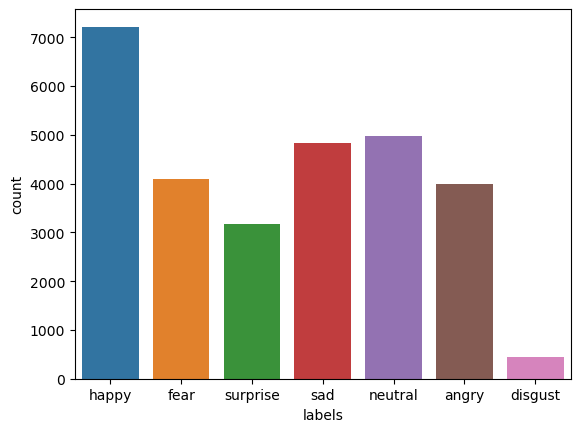

In [7]:
sns.countplot(data=train, x='labels')

### This mean it is Unbalanced Data

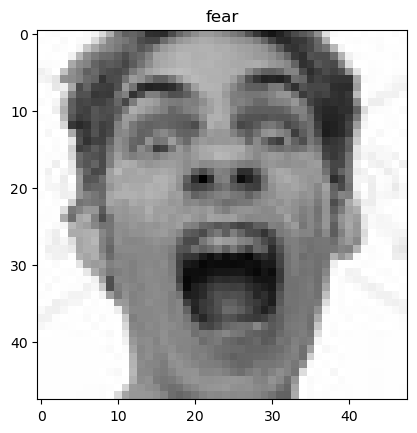

In [8]:
sample_img = load_img(train['images'][3])
plt.title(train['labels'][3])
plt.imshow(sample_img);

In [9]:
from PIL import Image
import numpy as np

image_path = train['images'][0]
pil_image = Image.open(image_path)

# Convert the PIL image to a NumPy array
np_image = np.array(pil_image)

# Get the shape of the NumPy array
height, width = np_image.shape
print("Image shape: ({}, {})".format(height, width))

Image shape: (48, 48)


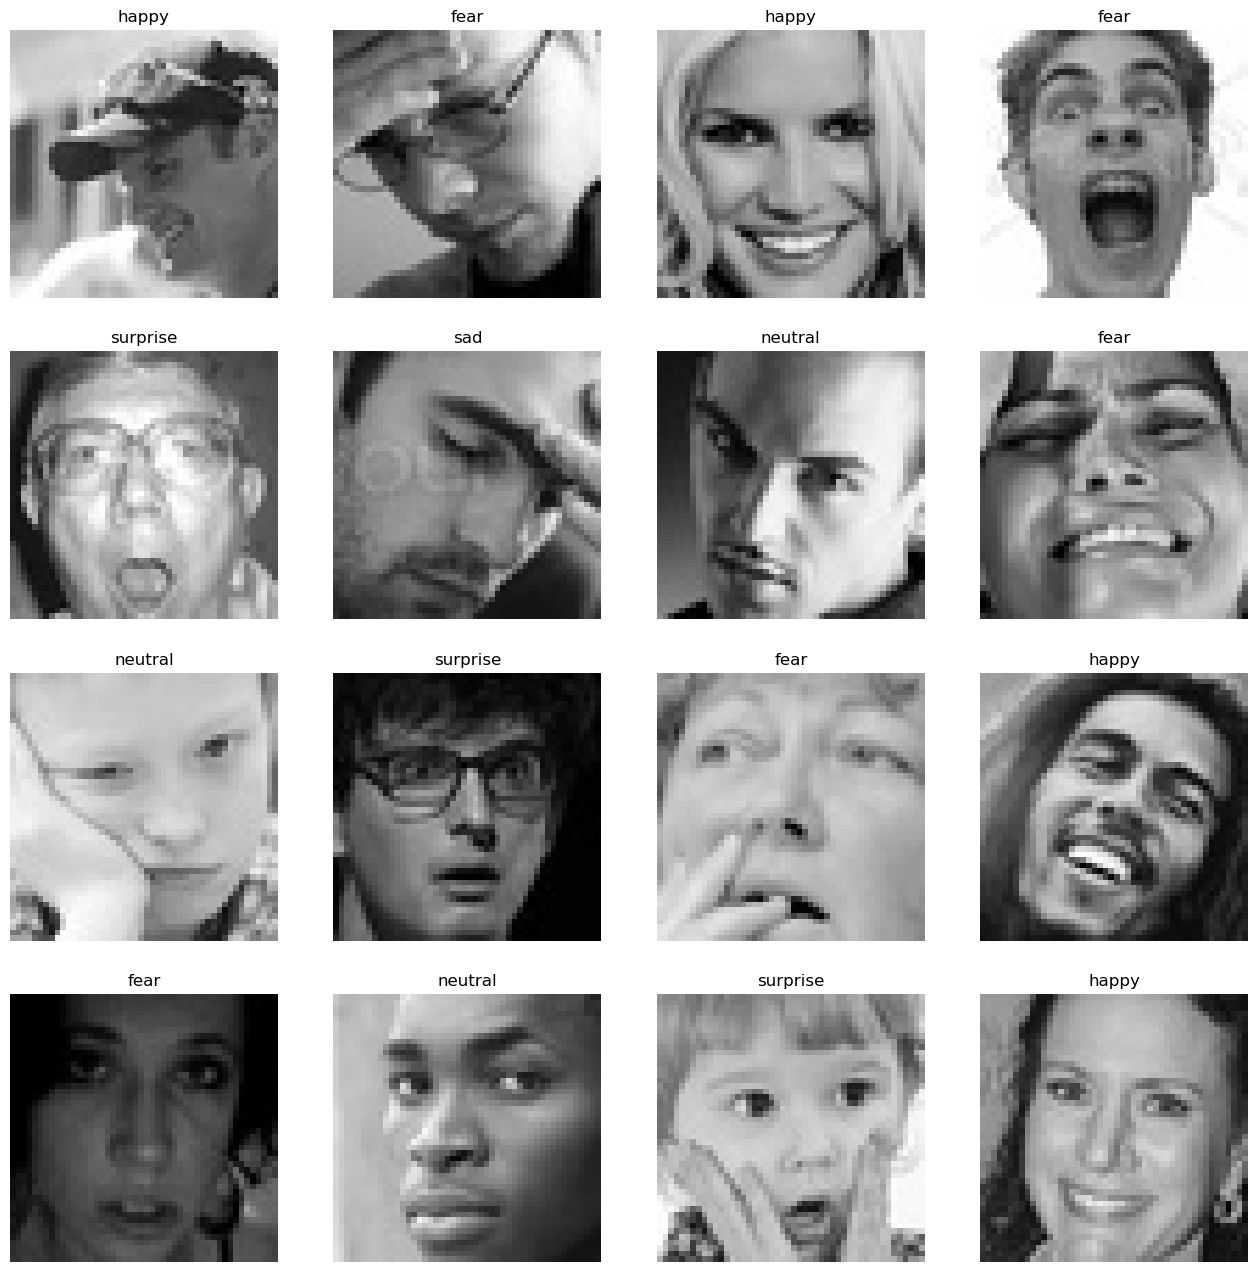

In [10]:
plt.figure(figsize=(16,16))
sample_imgs = train.iloc[0:16]
for idx, img, label in sample_imgs.itertuples():
    plt.subplot(4,4,idx+1)
    img = load_img(img)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)
    

# Preprocessing

In [11]:
def read_images(images):
    features=[]
    for img_path in tqdm(images):
        img = load_img(img_path,grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features

In [12]:
X_train = read_images(train['images'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [13]:
X_test = read_images(test['images'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [14]:
X_test.shape

(7178, 48, 48, 1)

In [15]:
## normalize the image
X_train = X_train/255.0
X_test = X_test/255.0

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['labels'])
y_train = le.transform(train['labels'])
y_test = le.transform(test['labels'])

In [17]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [18]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [19]:
input_shape = (48, 48, 1)
output_class = 7

# Model

In [20]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [21]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100


2023-06-21 18:30:29.237949: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


225/225 [==============================] - 30s 56ms/step - loss: 1.8231 - accuracy: 0.2486 - val_loss: 1.8155 - val_accuracy: 0.2471
Epoch 2/100
225/225 [==============================] - 12s 53ms/step - loss: 1.7983 - accuracy: 0.2525 - val_loss: 1.7807 - val_accuracy: 0.2554
Epoch 3/100
225/225 [==============================] - 11s 51ms/step - loss: 1.7264 - accuracy: 0.2897 - val_loss: 1.6272 - val_accuracy: 0.3440
Epoch 4/100
225/225 [==============================] - 12s 53ms/step - loss: 1.6026 - accuracy: 0.3682 - val_loss: 1.4306 - val_accuracy: 0.4423
Epoch 5/100
225/225 [==============================] - 11s 51ms/step - loss: 1.4882 - accuracy: 0.4226 - val_loss: 1.3484 - val_accuracy: 0.4869
Epoch 6/100
225/225 [==============================] - 12s 52ms/step - loss: 1.4115 - accuracy: 0.4538 - val_loss: 1.3154 - val_accuracy: 0.4960
Epoch 7/100
225/225 [==============================] - 12s 53ms/step - loss: 1.3751 - accuracy: 0.4709 - val_loss: 1.2506 - val_accuracy: 0.51

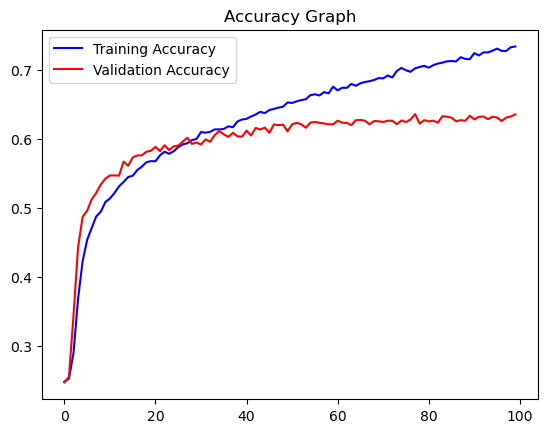

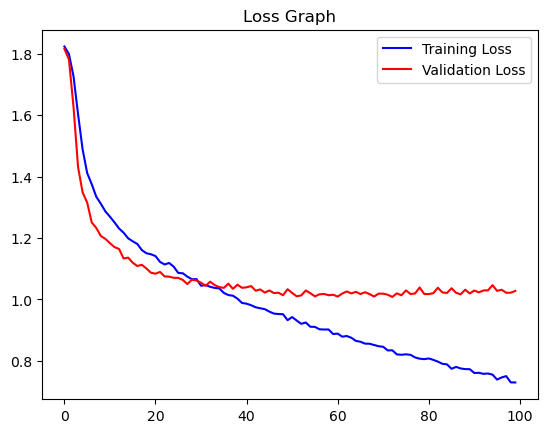

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

# Prediction

True Output:  sad
1/1 [==============================] - 0s 320ms/step
Predicted Output: sad


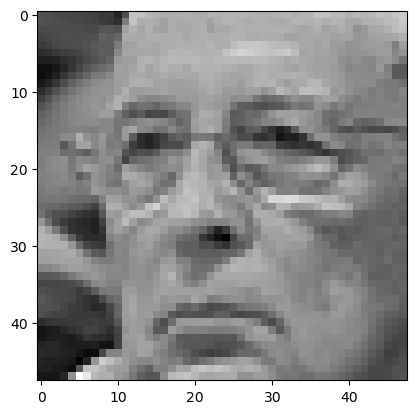

In [23]:
import random
img_idx = random.randint(0,len(test))
print("True Output: ",test['labels'][img_idx])
pred = model.predict(X_test[img_idx].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(X_test[img_idx].reshape(48, 48), cmap='gray');

True Output:  angry
1/1 [==============================] - 0s 22ms/step
Predicted Output: sad


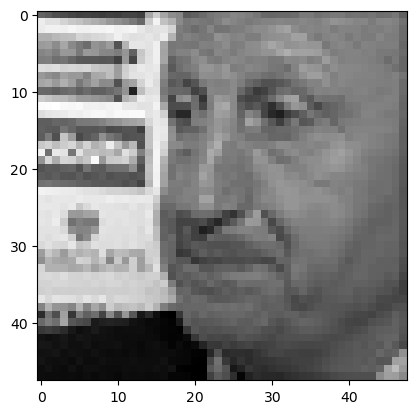

In [24]:
img_idx = random.randint(0,len(test))
print("True Output: ",test['labels'][img_idx])
pred = model.predict(X_test[img_idx].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(X_test[img_idx].reshape(48, 48), cmap='gray');

True Output:  happy
1/1 [==============================] - 0s 19ms/step
Predicted Output: happy


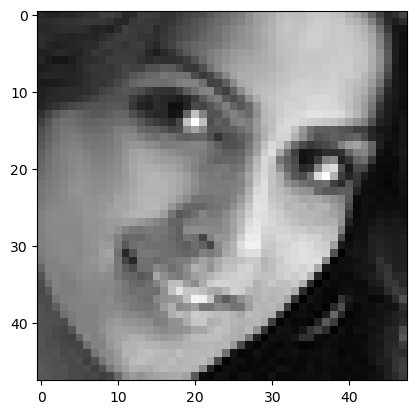

In [25]:
img_idx = random.randint(0,len(test))
print("True Output: ",test['labels'][img_idx])
pred = model.predict(X_test[img_idx].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(X_test[img_idx].reshape(48, 48), cmap='gray');

# Thanks